# <u>Submission instructions</u>
### Submission in pairs unless otherwise authorized
<ul style="font-size: 17px">
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p style="font-size: 17px">
You should submit three files:
</p>
<ul style="font-size: 17px">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p style="font-size: 17px">
All files should be in the following format: "HW2_ID1_ID2.file"
<br>
Good Luck!
</p>

# Question 1 - Generalizrtion and Overfit (30 pt)

<p style="font-size: 17px"> In this exercise, we will demonstrate overfitting to random labels.The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e.,each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
What is the accuracy value of the test data? Explain
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data = torch.utils.data.Subset(mnist_train, range(128)) # first 128 samples
test_data = mnist_test

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=16, shuffle=False)

# Generating random labels
random_labels = torch.randint(0, 2, (128,)).to(device)
train_loader.dataset.dataset.targets[:128] = random_labels

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def train(model, train_loader, test_loader, optimizer, criterion,
          num_epochs=5):
    
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
        
        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(100 * correct_train / total_train)
        
        # Eval
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                random_labels = torch.randint(0, 2, (16,)).to(device)
                target = random_labels
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()
        
        test_loss_list.append(test_loss / len(test_loader))
        test_acc_list.append(100 * correct_test / total_test)

    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

In [5]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

train_loss_list, train_acc_list, test_loss_list, test_acc_list = train(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)
if device == 'cuda':
    torch.cuda.empty_cache()

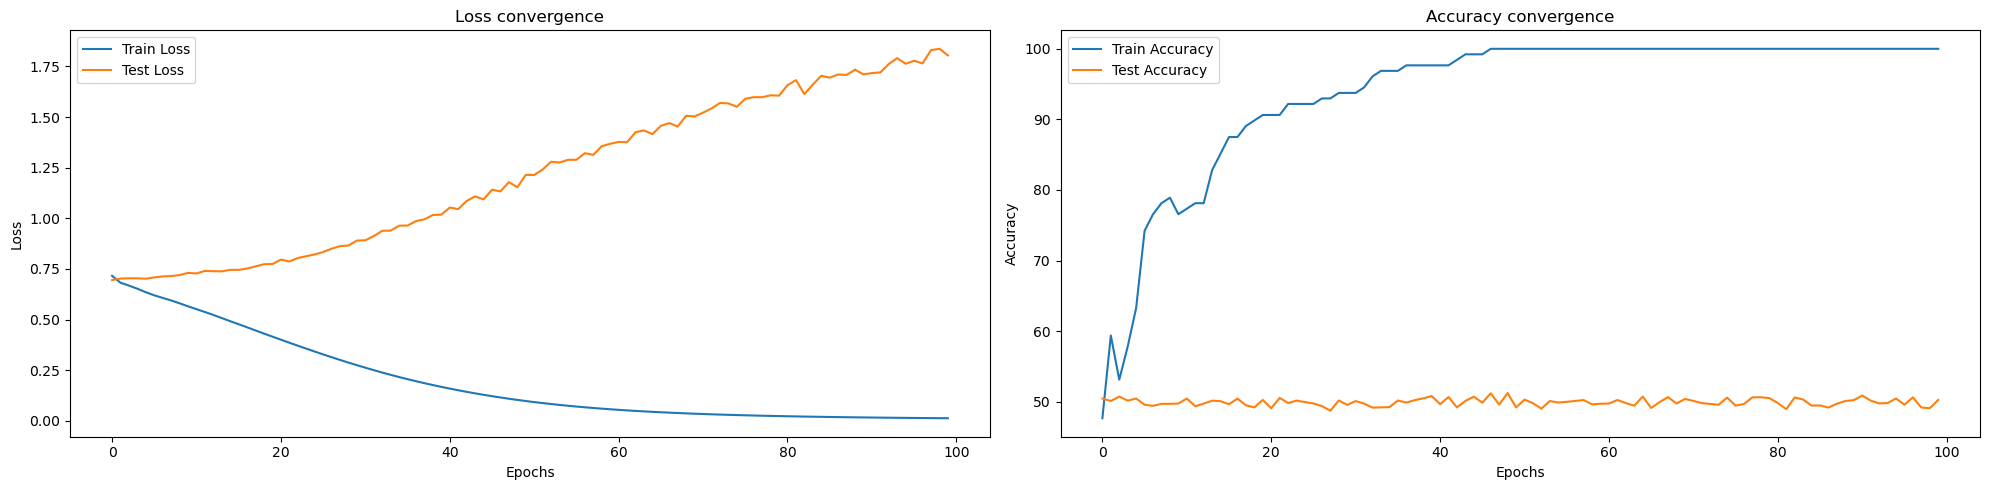

The Train Loss:  0.012497678399085999
The Test Accurecy:  50.25


In [6]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title('Loss convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.title('Accuracy convergence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

final_test_accuracy = test_acc_list[-1]
print("The Train Loss: ", train_loss_list[-1])
print("The Test Accurecy: ", final_test_accuracy)

<p style="font-size:18px;">By assigning random labels to the training data and using a sufficiently complex model like a fully connected network, you can achieve a low training loss (~0), this demonstrates the model's capacity to memorize even random noise without deriving any genuine patterns or relationships from the data. </br>
As the model over fitted on random noise, any new input he gets, is basically assigned a random label, which leads to the accuracy we witness here on binary labels, given each one a 50-50 chance to be assigned the right value.</p>

********************

<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

### Exercise
<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks. 
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example. 
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

### a) EDA (10 pt)

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

*****************************

<p style="font-size:18px;">To feed the models the data we have, we need to process it into Numerical data.</br>
</br>
First, we skip the first line, which contains the headers. We then split each line into the sentiment and the sentence by splitting the line at the first ",". We assign an integer "hash" to the sentiments to feed numerical data to the model.</br>
</br>
Now, we need to parse and embbed the sentences into numerical values aswell. first we will tokenize the sentences. When tokenizing, we aim to preserve as much information as possible about the structure of the sentence and its sentiment. To achieve this, we will use regex.</br>
</br>
After tokenizing, we will use the pretrained glove-twitter-200 embeddings without updating them during training on the tokenized sentences. To enhance the embeddings, we will add a few features to the vectors to gather more information about each word, which helps the model learn better.</br>
</br>
In the end, we obtain two lists: one of numerical sentiments and one of an array of embedded tokenized arrays.</br></p>

*****************************

### b) Main (50 pt)

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

*****************************

Getting the Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
import gensim
from gensim import downloader
import string
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import nltk
from nltk.corpus import stopwords
import gc
import os

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hunte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

In [3]:
glove = downloader.load('glove-twitter-200')

In [4]:
english_stopwords = set(stopwords.words('english'))

In [5]:
sentiments = {}
count = 0

def throw_a_word(word):
    features = [
        word.lower() in english_stopwords,                                                # Is a stopword
        word.isdigit(),                                                                   # Is numeric
        any(char.isdigit() for char in word),                                             # Contains a digit
        bool(re.search(r'http[s]?://', word)),                                            # is a URL
        re.match(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', word) is not None,  # is an email
    ]
    return any(features)


def fetch_data(path, isTrain=True):
    sentences, emotions = [], []
    with open(path, 'r', encoding='utf-8') as file:
        file.readline()
        for line in file:
            label, sentence_raw = line.strip().split(',', 1)
            sentence = sentence_raw[1:-1] if sentence_raw.startswith('"') else sentence_raw
            sentence = re.split(r'[ ,.]+', sentence.lower())
            sentence = re.split(r'([\W+])', " ".join([word for word in sentence if not throw_a_word(word)]))
            sentence = [word for word in sentence if word not in string.punctuation + " " and not throw_a_word(word)]
            if not sentence == []:
                sentences.append(sentence)
                emotions.append(parse_emotion(label, isTrain))

    return sentences, emotions
    

def parse_emotion(emotion, isTrain=True):
    if emotion not in sentiments:
        global count
        if isTrain:
            sentiments[emotion] = count
            count += 1
        else:
            return -1
        
    return sentiments[emotion]
        

In [6]:
class TwitterDataset(Dataset):
    def __init__(self, sentences, emotions, glove):
        self.sentences = sentences
        self.emotions = emotions
        self.vocab = self.build_vocab(glove)
        self.embeddings_matrix = self.build_embedding_matrix(glove, self.vocab)
        self.max_word_len = max([len(word) for sentence in sentences for word in sentence])

    def build_vocab(self, glove):
        vocab = {"<PAD>": 0, "<UNK>": 1}
        idx = 2
        glove_vocab = None
        if gensim.__version__ < '4.0.0':
            glove_vocab = glove.vocab
        else:
            glove_vocab = glove.key_to_index

        for word in glove_vocab:
            vocab[word] = idx
            idx += 1
        return vocab

    def build_embedding_matrix(self, glove, vocab):
        matrix_len = len(vocab) + 1
        weights_matrix = np.zeros((matrix_len, 200))

        for word, index in vocab.items():
            try:
                weights_matrix[index] = glove[word]
            except KeyError:
                pass #weights_matrix[index] = np.random.normal(scale=0.6, size=(200,))

        return torch.tensor(weights_matrix, dtype=torch.float)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words, emotions = self.sentences[idx], self.emotions[idx]
        x_indices = [self.vocab.get(word.lower(), self.vocab["<UNK>"]) for word in words]
        x_features = [[0]] * len(words)
        return (torch.tensor(x_indices, dtype=torch.long), torch.tensor(x_features, dtype=torch.float)), torch.tensor(
            emotions, dtype=torch.long)


def collate_fn(batch):
    sentence_data, emotion_data = zip(*batch)
    sentences, features = zip(*sentence_data)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    emotion_data = torch.tensor(emotion_data, dtype=torch.long) # no padding needed

    return (sentences_padded, features_padded), emotion_data

In [7]:
train_path = 'trainEmotions.csv'
test_path = 'testEmotions.csv'

In [23]:
sentences, emotions = fetch_data(train_path)
sentences_test, emotions_test = fetch_data(test_path, False)

train_dataset = TwitterDataset(sentences, emotions, glove)
test_dataset = TwitterDataset(sentences_test, emotions_test, glove)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

The RNN

In [9]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, feature_dim, hidden_dim, linear_dim, num_layers, rnn_dropout, dropout, output_dim, pretrained_embeddings):
        super().__init__()
        vocab_size, embedding_dim = pretrained_embeddings.size()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)  # freeze embeddings

        self.rnn = nn.RNN(embedding_dim + feature_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, linear_dim)
        self.fc2 = nn.Linear(linear_dim, output_dim)
        self.activation = nn.ReLU()
        self.rnn_dropout = nn.Dropout(rnn_dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_indices, x_features = x
        embedded = self.embedding(x_indices)

        rnn_input = torch.cat((embedded, x_features), dim=2)
        rnn_out, _ = self.rnn(rnn_input)
        rnn_out = self.rnn_dropout(rnn_out[:, -1, :])

        out = self.fc1(rnn_out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

The LSTM

In [10]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, feature_dim, hidden_dim, linear_dim, num_layers, lstm_dropout, dropout, output_dim, pretrained_embeddings):
        super().__init__()
        vocab_size, embedding_dim = pretrained_embeddings.size()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)  # freeze embeddings

        self.lstm = nn.LSTM(embedding_dim + feature_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                            bidirectional=True)

        self.fc1 = nn.Linear(hidden_dim * 2, linear_dim)
        self.fc2 = nn.Linear(linear_dim, output_dim)
        self.activation = nn.Mish()
        self.lstm_dropout = nn.Dropout(lstm_dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_indices, x_features = x
        embedded = self.embedding(x_indices)
        embedded = self.dropout(embedded)
        lstm_input = torch.cat((embedded, x_features), dim=2)
        lstm_out, _ = self.lstm(lstm_input)
        lstm_out = self.lstm_dropout(lstm_out[:, -1, :])
        
        out = self.fc1(lstm_out)
        out = self.activation(out)
        out = self.fc2(out)

        return out

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # here we would use cuda if available
# device = torch.device("cpu")
torch.manual_seed(0)
np.random.seed(0)

# Hyperparameters
HIDDEN_DIM = 256
OUTPUT_DIM = 3
EPOCHS = 5
LEARNING_RATE = 0.005
SCHEDULER_GAMMA = 0.4
SCHEDULER_STEP_SIZE = 1
BATCH_SIZE = 32
NUM_LAYERS = 2
LSTM_DROPOUT = 0.3
DROPOUT = 0.4
LINEAR_DIM = 128

EMBEDDING_DIM = 200
FEATURE_DIM = 1

In [22]:
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    correct, total = 0, 0
    for X, labels in data_loader:
        X = (X[0].to(device), X[1].to(device))
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    return train_accuracy

def evaluate(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for X, labels in data_loader:
            X = (X[0].to(device), X[1].to(device))
            labels = labels.to(device)

            predictions = model(X)
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            predictions = torch.argmax(predictions, dim=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    test_accuracy = correct / total
    return test_accuracy, all_predictions, all_labels

def run(model, train_loader, test_loader, device, plot=True, info=True, lr=LEARNING_RATE, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA, epochs=EPOCHS):
    train_accuracies, test_accuracies = [], []
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(epochs):
        train_acc = train(model, train_loader, optimizer, criterion, device)
        test_acc, predictions, labels = evaluate(model, test_loader, device)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        scheduler.step()

    if plot:
        # Accuracies plot
        print(f'Final Train Accuracy: {train_accuracies[-1]:.4f}')
        print(f'Final Test Accuracy: {test_accuracies[-1]:.4f}')
        plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Train vs Test Accuracies')
        plt.show()
        
        # Confusion matrix
        labels_for_cm = list(sentiments.keys())
        cm = confusion_matrix(labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_for_cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.show()
    elif info:
        print(f'Final Train Accuracy: {train_accuracies[-1]:.4f}')
        print(f'Final Test Accuracy: {test_accuracies[-1]:.4f}')

    return test_accuracies[-1]


In [13]:
def cuda_empty_cach(model):
    if torch.cuda.is_available():
        del model
        torch.cuda.empty_cache()
        gc.collect()

In [14]:
rnn_model = RNN(embedding_dim=EMBEDDING_DIM, feature_dim=FEATURE_DIM, hidden_dim=HIDDEN_DIM,
                linear_dim=LINEAR_DIM,
                num_layers=NUM_LAYERS, rnn_dropout=LSTM_DROPOUT, dropout=DROPOUT, output_dim=OUTPUT_DIM,
                pretrained_embeddings=train_dataset.embeddings_matrix).to(device)

In [15]:
print("vanilla RNN Model")
run(rnn_model, train_loader, test_loader, device, False)
cuda_empty_cach(rnn_model)

vanilla RNN Model
Final Train Accuracy: 0.3836
Final Test Accuracy: 0.3661


In [17]:
cross_val_dict = {
    'HIDDEN_DIM': [16, 32, 64, 128, 256, 512],
    'EPOCHS': [3, 5, 10, 15],
    'LEARNING_RATE': [0.001, 0.005, 0.01, 0.05, 0.1],
    'SCHEDULER_GAMMA': [0.005, 0.01, 0.05, 0.1, 0.5],
    'SCHEDULER_STEP_SIZE': [1, 2, 3],
    'BATCH_SIZE': [4, 8, 16, 32, 64, 128],
    'NUM_LAYERS': [1, 2, 3, 4, 5],
    'LSTM_DROPOUT': [0.1, 0.2, 0.3, 0.4, 0.5],
    'DROPOUT': [0.1, 0.2, 0.3, 0.4, 0.5],
    'LINEAR_DIM': [16, 32, 64, 128, 256, 512],
}

print(sum([len(lst) for lst in cross_val_dict.values()]))

50


BiLSTM Model with initial hyperparameters:
Final Train Accuracy: 0.5919
Final Test Accuracy: 0.5032


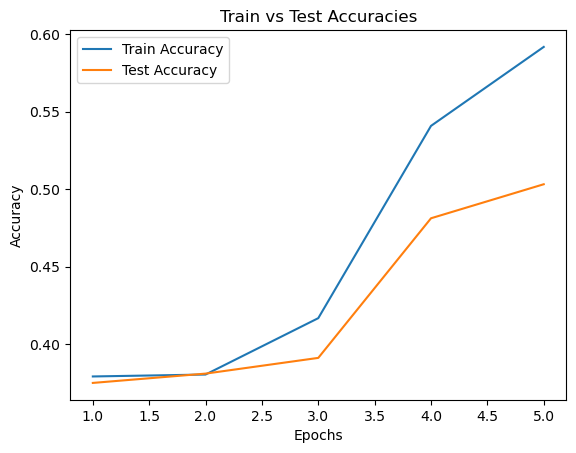

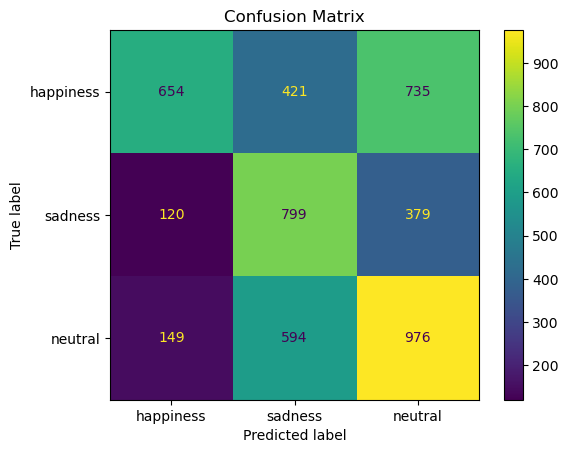


Finetuning hyperparameters:

HIDDEN_DIM: [(16, 0.54650921897659), (32, 0.5560389475864926), (64, 0.5361508183136524), (128, 0.5537600994406464), (256, 0.5492024031489539), (512, 0.4613631655272426)]
max test accuracy for HIDDEN_DIM: 0.5560389475864926 with HIDDEN_DIM = 32

EPOCHS: [(3, 0.5438160348042262), (5, 0.5539672674539051), (10, 0.5469235550031075), (15, 0.5547959395069402)]
max test accuracy for EPOCHS: 0.5547959395069402 with EPOCHS = 15

LEARNING_RATE: [(0.001, 0.5614253159312202), (0.005, 0.5162626890408121), (0.01, 0.37497410399834263), (0.05, 0.37497410399834263), (0.1, 0.37497410399834263)]
max test accuracy for LEARNING_RATE: 0.5614253159312202 with LEARNING_RATE = 0.001

SCHEDULER_GAMMA: [(0.005, 0.35612181479179617), (0.01, 0.3739382639320489), (0.05, 0.43256681168427596), (0.1, 0.5539672674539051), (0.5, 0.5417443546716387)]
max test accuracy for SCHEDULER_GAMMA: 0.5539672674539051 with SCHEDULER_GAMMA = 0.1

SCHEDULER_STEP_SIZE: [(1, 0.5284856018230785), (2, 0.57199

In [27]:
cur_hyp_dict_init = {
    'HIDDEN_DIM': HIDDEN_DIM,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'SCHEDULER_GAMMA': SCHEDULER_GAMMA,
    'SCHEDULER_STEP_SIZE': SCHEDULER_STEP_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'NUM_LAYERS': NUM_LAYERS,
    'LSTM_DROPOUT': LSTM_DROPOUT,
    'DROPOUT': DROPOUT,
    'LINEAR_DIM': LINEAR_DIM,
}

def make_bilstm_model(cur_hyp_dict):
    return BiLSTM(embedding_dim=EMBEDDING_DIM, feature_dim=FEATURE_DIM, hidden_dim=cur_hyp_dict['HIDDEN_DIM'],
                    linear_dim=cur_hyp_dict['LINEAR_DIM'], num_layers=cur_hyp_dict['NUM_LAYERS'], lstm_dropout=cur_hyp_dict['LSTM_DROPOUT'], 
                    dropout=cur_hyp_dict['DROPOUT'], output_dim=OUTPUT_DIM,
                    pretrained_embeddings=train_dataset.embeddings_matrix).to(device)

cur_hyp_dict = cur_hyp_dict_init.copy()

accuracies = {key: [] for key in cross_val_dict.keys()}
max_accuracies = {}

bilstm_model = make_bilstm_model(cur_hyp_dict)

print("BiLSTM Model with initial hyperparameters:")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
max_acc = run(bilstm_model, train_loader, test_loader, device, plot=True)
cuda_empty_cach(bilstm_model)

print("\nFinetuning hyperparameters:\n")
for key in cross_val_dict.keys():
    for hp in cross_val_dict[key]:
        cur_hyp_dict[key] = hp

        bilstm_model = make_bilstm_model(cur_hyp_dict)

        train_loader = DataLoader(train_dataset, batch_size=cur_hyp_dict['BATCH_SIZE'], shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=cur_hyp_dict['BATCH_SIZE'], shuffle=True, collate_fn=collate_fn)
        
        accuracies[key].append(run(bilstm_model, train_loader, test_loader, device, plot=False, info=False, 
                                   lr=cur_hyp_dict['LEARNING_RATE'], step_size=cur_hyp_dict['SCHEDULER_STEP_SIZE'], 
                                   gamma=cur_hyp_dict['SCHEDULER_GAMMA'], epochs=cur_hyp_dict['EPOCHS']))
        cuda_empty_cach(bilstm_model)

    cur_hyp_dict[key] = cur_hyp_dict_init[key]
    print(f'{key}: {[(hp, acc) for hp, acc in zip(cross_val_dict[key], accuracies[key])]}')
    argmax_acc, max_acc = max(enumerate(accuracies[key]), key=lambda t: list(reversed(t)))
    max_accuracies[key] = {'argmax': cross_val_dict[key][argmax_acc], 'max': max_acc}
    print(f'max test accuracy for {key}: {max_acc} with {key} = {cross_val_dict[key][argmax_acc]}\n')

for key in max_accuracies.keys():
    cur_hyp_dict[key] = max_accuracies[key]['argmax']

Final Train Accuracy: 0.6703
Final Test Accuracy: 0.5475


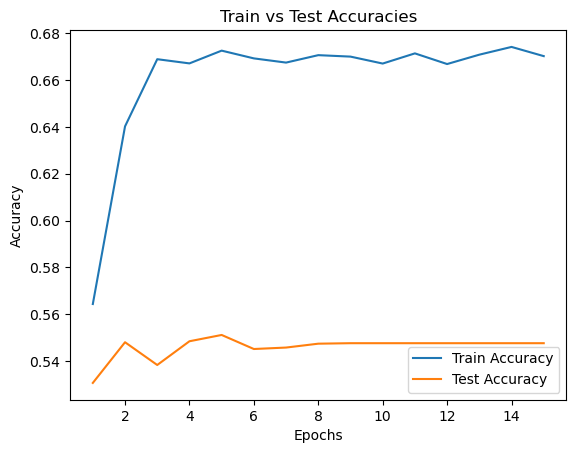

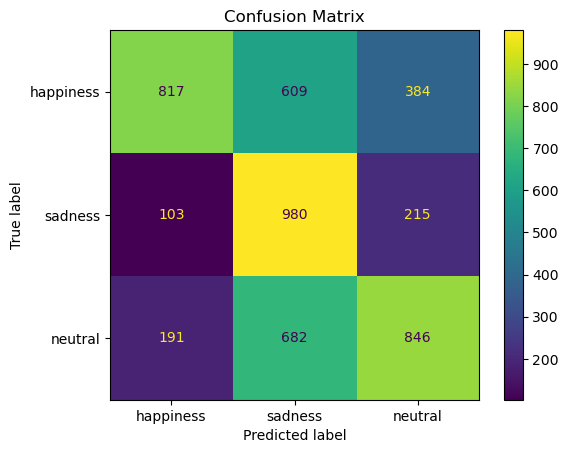

Final combination:
{'HIDDEN_DIM': 32, 'EPOCHS': 15, 'LEARNING_RATE': 0.001, 'SCHEDULER_GAMMA': 0.1, 'SCHEDULER_STEP_SIZE': 2, 'BATCH_SIZE': 16, 'NUM_LAYERS': 2, 'LSTM_DROPOUT': 0.1, 'DROPOUT': 0.4, 'LINEAR_DIM': 256}
Final test accuracy: 0.5475450590428838


In [33]:
bilstm_model = make_bilstm_model(cur_hyp_dict)

train_loader = DataLoader(train_dataset, batch_size=cur_hyp_dict['BATCH_SIZE'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=cur_hyp_dict['BATCH_SIZE'], shuffle=False, collate_fn=collate_fn)

final_acc = run(bilstm_model, train_loader, test_loader, device, plot=True, 
                                   lr=cur_hyp_dict['LEARNING_RATE'], step_size=cur_hyp_dict['SCHEDULER_STEP_SIZE'], 
                                   gamma=cur_hyp_dict['SCHEDULER_GAMMA'], epochs=cur_hyp_dict['EPOCHS'])
cuda_empty_cach(bilstm_model)
print(f'Final combination:\n{cur_hyp_dict}\nFinal test accuracy: {final_acc}')

*****************************

### c) Discussion (10 pt)
<p style="font-size: 17px">
Discuss the differences in the methods you have tried. 
</p>

<p style="font-size:18px;">First we focused on how we should process the data, we wanted to make sure that the model will get as much information it can to be able to learn from, after looking online we decided to used regex to tokenize the data and the glove model to embbed it afterwards. </br>
</br>
From the get-go, we knew the RNN wouldn't be able to beat the performance of the LSTM model, so we focused on the LSTM model and modified it to run as a simple vanilla RNN later on.</br>
</br>
We built the model as a one-directional LSTM, using only the base embeddings on the tokenized sentences. After witnessing poor performance, we decided to make the model bi-directional. At this stage we had a biLSTM model with sentences tokenized and embedded with the glove-twitter-200 model, each word of size 200.</br>
We then tried different optimizers and loss functions, but quickly saw that the adam optimizer and the CE loss worked well for this task. We also added a scheduler to decrease the learning rate every few steps.</br>
</br>
After confirming that miLSTM brought us very close to the desired accuracy goal, we focused on fine-tuning the parameters for the model. We then copied the BiLSTM model and adjusted it to fit the vanilla RNN.</br>
to test different params we just run a lot of different for loops, iterating over different values, each time setting the seed to 0 to make sure its consistant.</br>
</br>
When running the models, we noticed that in the first epochs, the models highly favored one of the sentiments. However, as the LSTM learns, it manages to classify more than one sentiment, while the RNN model does not. Possible causes can be the vanishing/exploding gradients in the RNN, or the fact that the bi-LSTM model can gather more information and learn better by processing data from both directions of the sentence, enabling it to process deeper meanings of the sentence (like sentiments).</p>